# Calibration of the market models


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os
import glob
import gzip
import warnings
#warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

### Import HFT data + Add mid price and spread column

In [2]:
def load_data(file_path):
    """Load and preprocess data from gzipped CSV file."""
    with gzip.open(file_path, 'rt') as f:
        df = pd.read_csv(f)
    
    # Convert timestamp to datetime
    df['datetime'] = pd.to_datetime(df['ets'], format='%Y%m%d:%H:%M:%S.%f')
    
    # Extract mid-price
    df['mid_price'] = (df['bp0'] + df['ap0']) / 2

    # add spread
    df['spread'] = df['ap0'] - df['bp0']
    
    return df

# Get all data files
bnpp_files = sorted(glob.glob('../../HFT/Data/BNPP/BNPP_*.csv.gz'))
sg_files = sorted(glob.glob('../../HFT/Data/SG/SG_*.csv.gz'))

print("BNPP files:", [os.path.basename(f) for f in bnpp_files])
print("SG files:", [os.path.basename(f) for f in sg_files])

# Load all day data for each stock for initial analysis
bnpp_data_dict = {}
sg_data_dict = {}
for file in bnpp_files:
    date_str = os.path.basename(file).split('_')[1].split('.')[0]
    bnpp_data_dict[date_str] = load_data(file)
for file in sg_files:
    date_str = os.path.basename(file).split('_')[1].split('.')[0]
    sg_data_dict[date_str] = load_data(file)

BNPP files: ['BNPP_20170117.csv.gz', 'BNPP_20170118.csv.gz', 'BNPP_20170119.csv.gz', 'BNPP_20170120.csv.gz', 'BNPP_20170123.csv.gz', 'BNPP_20170124.csv.gz', 'BNPP_20170125.csv.gz', 'BNPP_20170126.csv.gz', 'BNPP_20170127.csv.gz', 'BNPP_20170130.csv.gz', 'BNPP_20170131.csv.gz', 'BNPP_20170201.csv.gz']
SG files: ['SG_20170117.csv.gz', 'SG_20170118.csv.gz', 'SG_20170119.csv.gz', 'SG_20170120.csv.gz', 'SG_20170123.csv.gz', 'SG_20170124.csv.gz', 'SG_20170125.csv.gz', 'SG_20170126.csv.gz', 'SG_20170127.csv.gz', 'SG_20170130.csv.gz', 'SG_20170131.csv.gz', 'SG_20170201.csv.gz']


In [3]:
# print one day of data for each stock
bnpp_data = bnpp_data_dict['20170201']  # Example date
sg_data = sg_data_dict['20170201']  # Example date
print("\nBNPP data shape:", bnpp_data.shape)
print("SG data shape:", sg_data.shape)

# Display the first few rows of each dataset
print("\nBNPP data sample:")
display(bnpp_data.head())

print("\nSG data sample:")
display(sg_data.head())


BNPP data shape: (452389, 13)
SG data shape: (701268, 13)

BNPP data sample:


,Unnamed: 0,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0,datetime,mid_price,spread
0,0,20170201:09:00:24.436107,A,60000,8,B,60000,8,60020,523,2017-02-01 09:00:24.436107,60010.0,20
1,1,20170201:09:00:25.803393,A,60080,671,B,60080,671,60090,200,2017-02-01 09:00:25.803393,60085.0,10
2,2,20170201:09:00:31.585838,A,60170,6792,B,60170,6792,60180,728,2017-02-01 09:00:31.585838,60175.0,10
3,3,20170201:09:01:00.456932,A,60050,157,B,60110,416,60220,931,2017-02-01 09:01:00.456932,60165.0,110
4,4,20170201:09:01:00.899891,C,60100,259,B,60110,416,60220,931,2017-02-01 09:01:00.899891,60165.0,110



SG data sample:


,Unnamed: 0,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0,datetime,mid_price,spread
0,0,20170201:09:00:31.585786,A,45980,4281,B,45980,4281,45990,516,2017-02-01 09:00:31.585786,45985.0,10
1,1,20170201:09:00:31.652328,A,46005,287,B,46005,287,46055,240,2017-02-01 09:00:31.652328,46030.0,50
2,2,20170201:09:01:00.022474,A,46060,109,S,45915,470,45980,210,2017-02-01 09:01:00.022474,45947.5,65
3,3,20170201:09:01:00.033876,A,45825,130,B,45915,470,45980,210,2017-02-01 09:01:00.033876,45947.5,65
4,4,20170201:09:01:00.119919,T,45980,210,S,45915,470,45985,444,2017-02-01 09:01:00.119919,45950.0,70


#### Spread calibration

In [4]:
# List the distinct spreads in each dataset (ordered)
bnpp_spreads = bnpp_data['spread'].unique()
bnpp_spreads.sort()
sg_spreads = sg_data['spread'].unique()
sg_spreads.sort()
print(f"\nBNPP distinct spreads ({len(bnpp_spreads)}):", bnpp_spreads)
print(f"SG distinct spreads ({len(sg_spreads)}):", sg_spreads)

# number of appearances of each spread in the dataset
bnpp_spread_counts = bnpp_data['spread'].value_counts().sort_index()
sg_spread_counts = sg_data['spread'].value_counts().sort_index()
print("\nBNPP spread counts:")
print(bnpp_spread_counts.head(5))  # Display top 5 spreads
print("\nSG spread counts:")
print(sg_spread_counts.head(5))  # Display top 5 spreads


BNPP distinct spreads (14): [ 10  20  30  40  50  60  70  80  90 100 110 120 130 140]
SG distinct spreads (24): [  5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90
  95 100 105 110 115 120]

BNPP spread counts:
spread
10    108562
20    241753
30     81851
40     13256
50      3383
Name: count, dtype: int64

SG spread counts:
spread
5     103819
10    253545
15    203052
20     91996
25     29671
Name: count, dtype: int64


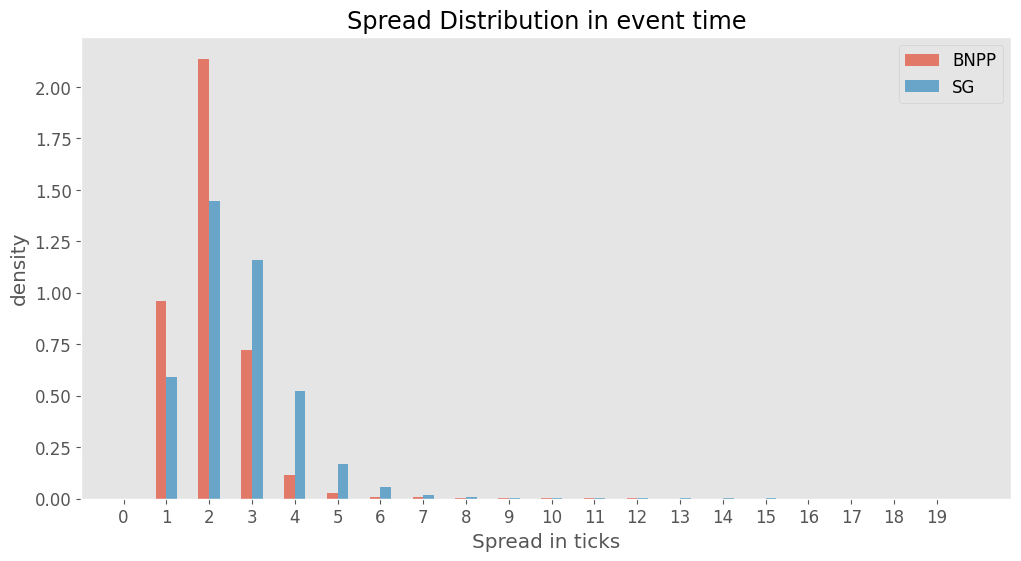

In [5]:
# Plot the spread distribution for BNPP and SG (frequency of each spread). bins = [1, 2, 3, .., 20], plot in the center of the bin.
plt.figure(figsize=(12, 6))
plt.hist(bnpp_data['spread']/10, bins=[i/4 for i in range(1, 80)], alpha=0.7, label='BNPP', density=True, align='left')
plt.hist(sg_data['spread']/5, bins=[i/4 for i in range(1, 80)], alpha=0.7, label='SG', density=True, align='right')
plt.xticks([i+0.125 for i in range(0, 20)], [str(i) for i in range(0, 20)])
plt.title('Spread Distribution in event time') 
plt.xlabel('Spread in ticks')
plt.ylabel('density')
plt.legend()
plt.grid()
plt.show()

In [6]:
ticks_size = 10.0
nb_ticks_max = 12

df = bnpp_data.copy()
df["spread shifted"] = df["spread"].shift()
df = df[ ["ets", "spread", "spread shifted"]]
df[["spread", "spread shifted"]]=df[["spread", "spread shifted"]]/ticks_size

spread_sequence = [ min(int(df.loc[0, "spread"]), nb_ticks_max) ]
ets_sequence = [df.loc[0, "ets"]]

for i in range(1, df.shape[0]):
    act_spread = min(int(df.loc[i, "spread"]), nb_ticks_max)
    if act_spread != spread_sequence[-1]:
        spread_sequence.append(act_spread)
        ets_sequence.append(df.loc[i, "ets"])

In [8]:
def compute_transition_matrix(sequence : list, nb_states : int = 12):
    """
    Compute the transition matrix from a sequence of states.
    
    Parameters:
    sequence (list): List of states (spread values)
    nb_states (int): Number of possible states (default=12)
    
    Returns:
    pd.dataframe: Transition matrix where entry (i,j) represents P(X_{t+1}=j|X_t=i)
    """
    # Initialize transition matrix with zeros
    transition_matrix = np.zeros((nb_states, nb_states))
    
    # Count transitions
    for i in range(len(sequence)-1):
        current_state = sequence[i] - 1  # -1 because states start at 1
        next_state = sequence[i+1] - 1
        
        # Only count transitions for states within our range
        if current_state < nb_states and next_state < nb_states:
            transition_matrix[current_state, next_state] += 1
    
    # Normalize rows to get probabilities
    row_sums = transition_matrix.sum(axis=1)
    # Avoid division by zero for states that never appear
    row_sums[row_sums == 0] = 1
    transition_matrix = transition_matrix / row_sums[:, np.newaxis]
    
    return pd.DataFrame(transition_matrix, index=[i+1 for i in range(nb_states)], columns=[i+1 for i in range(nb_states)])

compute_transition_matrix(spread_sequence, nb_states = nb_ticks_max)

,1,2,3,4,5,6,7,8,9,10,11,12
1,0.000000,0.971864,0.021964,0.004538,0.000363,0.000363,0.000000,0.000182,0.000363,0.000182,0.000182,0.000000
2,0.532415,0.000000,0.463235,0.003728,0.000414,0.000104,0.000104,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.055577,0.804149,0.000000,0.136658,0.002094,0.001142,0.000381,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.056902,0.068493,0.667018,0.000000,0.186512,0.007376,0.009484,0.002107,0.001054,0.000000,0.000000,0.001054
5,0.054622,0.029412,0.067227,0.655462,0.000000,0.159664,0.025210,0.000000,0.008403,0.000000,0.000000,0.000000
6,0.034483,0.045977,0.068966,0.045977,0.448276,0.000000,0.321839,0.034483,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.013333,0.053333,0.080000,0.040000,0.413333,0.000000,0.320000,0.040000,0.040000,0.000000,0.000000
8,0.035088,0.000000,0.000000,0.017544,0.035088,0.035088,0.473684,0.000000,0.333333,0.035088,0.035088,0.000000
9,0.045455,0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,0.500000,0.000000,0.250000,0.090909,0.068182
10,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.100000,0.466667,0.000000,0.133333,0.200000


In [42]:
def count_spreadTransition_by_period(ets_sequence: list, period_minutes: int = 30):
    """
    Calculate the rate of spread transitions per second for each time period.
    
    Parameters:
    ets_sequence (list): List of timestamps in format 'YYYYMMDD:HH:MM:SS.ffffff'
    period_minutes (int): Size of the time period in minutes (default=30)
    
    Returns:
    dict: Time periods as keys and rates (changes per second) as values
    """
    # Initialize counter dictionary
    period_counts = {}
    period_first_time = {}
    period_last_time = {}
    
    # Count elements for each period and track timestamps
    for timestamp in ets_sequence:
        hour = int(timestamp.split(':')[1])
        minute = int(timestamp.split(':')[2])
        second = float(timestamp.split(':')[3])
        
        # Calculate period based on the given minutes
        period_number = minute // period_minutes
        period = f"{hour:02d}:{period_number * period_minutes:02d}"
        
        # Track first and last timestamp for each period
        total_seconds = hour * 3600 + minute * 60 + second
        if period not in period_first_time:
            period_first_time[period] = total_seconds
        period_last_time[period] = total_seconds
        
        period_counts[period] = period_counts.get(period, 0) + 1
    
    # Convert counts to rates
    for period in period_counts:
        if period == list(period_counts.keys())[-1]:  # Last period
            period_duration = period_last_time[period] - period_first_time[period]
        else:
            period_duration = period_minutes * 60
            
        if period_duration > 0:  # Avoid division by zero
            period_counts[period] = period_counts[period] / period_duration
    
    # Sort by period
    sorted_counts = dict(sorted(period_counts.items()))
    
    return sorted_counts

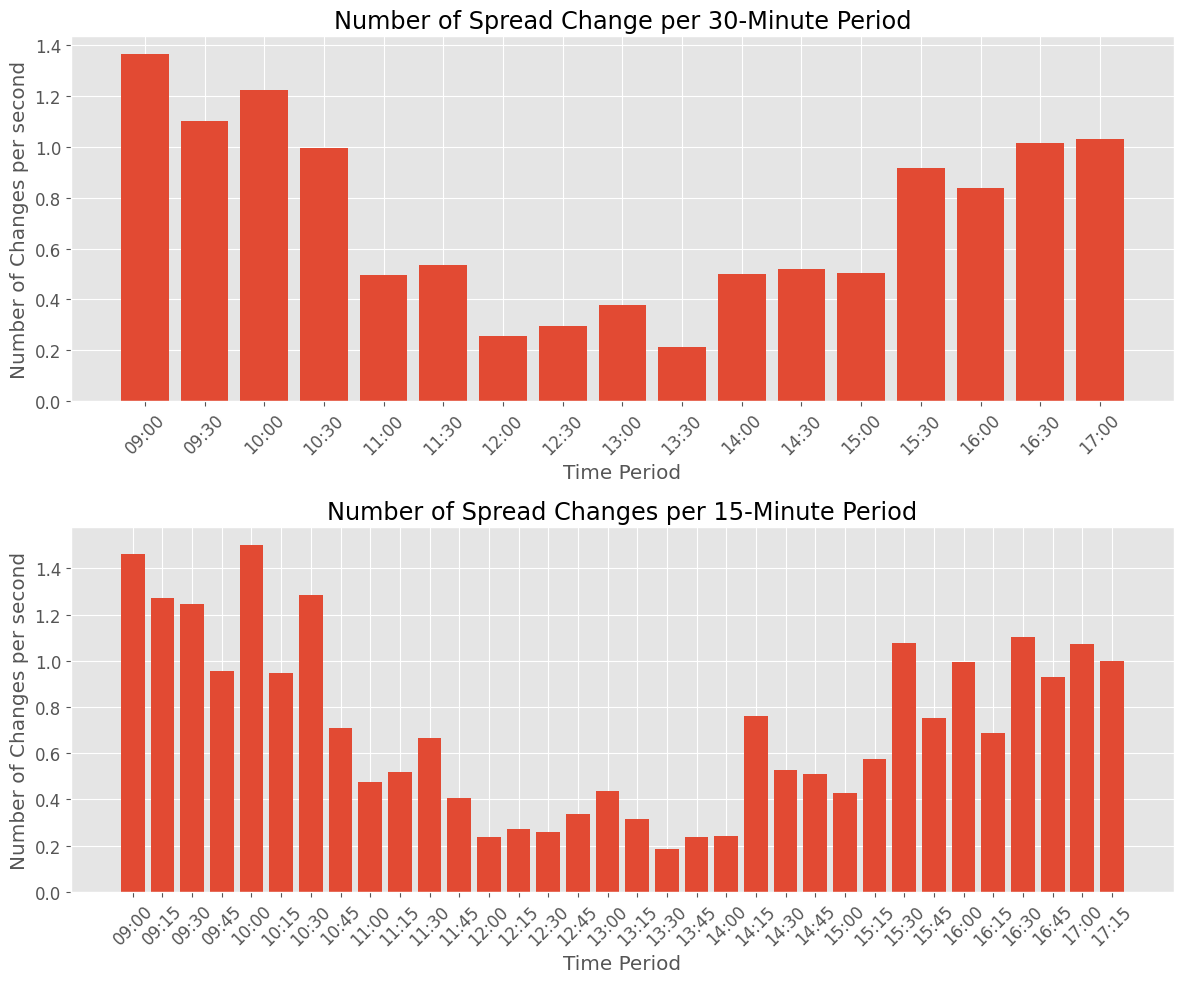

In [44]:
# Get the counts for different periods
thirty_min_counts = count_spreadTransition_by_period(ets_sequence, 30)
fifteen_min_counts = count_spreadTransition_by_period(ets_sequence, 15)

# Plot the results for both periods
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# 30-minute periods plot
ax1.bar(thirty_min_counts.keys(), thirty_min_counts.values())
ax1.set_title('Number of Spread Change per 30-Minute Period')
ax1.set_xlabel('Time Period')
ax1.set_ylabel('Number of Changes per second')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True)

# 15-minute periods plot
ax2.bar(fifteen_min_counts.keys(), fifteen_min_counts.values())
ax2.set_title('Number of Spread Changes per 15-Minute Period')
ax2.set_xlabel('Time Period')
ax2.set_ylabel('Number of Changes per second')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True)

plt.tight_layout()
plt.show()

### Estimation of execution parameters

In [62]:
bnpp_data.head(35)

,Unnamed: 0,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0,datetime,mid_price,spread
0,0,20170201:09:00:24.436107,A,60000,8,B,60000,8,60020,523,2017-02-01 09:00:24.436107,60010.0,20
1,1,20170201:09:00:25.803393,A,60080,671,B,60080,671,60090,200,2017-02-01 09:00:25.803393,60085.0,10
2,2,20170201:09:00:31.585838,A,60170,6792,B,60170,6792,60180,728,2017-02-01 09:00:31.585838,60175.0,10
3,3,20170201:09:01:00.456932,A,60050,157,B,60110,416,60220,931,2017-02-01 09:01:00.456932,60165.0,110
4,4,20170201:09:01:00.899891,C,60100,259,B,60110,416,60220,931,2017-02-01 09:01:00.899891,60165.0,110
5,5,20170201:09:01:00.902274,C,60040,18,B,60110,416,60220,931,2017-02-01 09:01:00.902274,60165.0,110
6,6,20170201:09:01:00.935428,A,60120,160,B,60120,160,60220,931,2017-02-01 09:01:00.935428,60170.0,100
7,7,20170201:09:01:00.935666,A,60120,257,B,60120,417,60220,931,2017-02-01 09:01:00.935666,60170.0,100
8,8,20170201:09:01:00.941796,A,60120,153,B,60120,570,60220,931,2017-02-01 09:01:00.941796,60170.0,100
9,9,20170201:09:01:01.003740,C,60120,160,B,60120,410,60220,931,2017-02-01 09:01:01.003740,60170.0,100


In [71]:
bnpp_data["dt"] = (bnpp_data["datetime"] - bnpp_data["datetime"].shift())

time_spent = bnpp_data[(bnpp_data["spread"] == 100) & (bnpp_data["ap0"] == 60220) ]["dt"].sum().total_seconds()
time_spent

10.284502

In [76]:
bnpp_data[bnpp_data["spread"] == 50]

,Unnamed: 0,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0,datetime,mid_price,spread,dt
96,96,20170201:09:01:05.596309,A,60240,126,S,60190,200,60240,126,2017-02-01 09:01:05.596309,60215.0,50,0 days 00:00:00.000041
1225,1225,20170201:09:02:25.039515,A,60160,135,S,60110,200,60160,135,2017-02-01 09:02:25.039515,60135.0,50,0 days 00:00:00.002160
1410,1410,20170201:09:02:43.585773,A,60150,171,S,60100,293,60150,171,2017-02-01 09:02:43.585773,60125.0,50,0 days 00:00:00.004857
1411,1411,20170201:09:02:43.587475,C,60000,1650,B,60100,293,60150,171,2017-02-01 09:02:43.587475,60125.0,50,0 days 00:00:00.001702
1412,1412,20170201:09:02:43.587485,C,60050,125,B,60100,293,60150,171,2017-02-01 09:02:43.587485,60125.0,50,0 days 00:00:00.000010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389638,389638,20170201:16:39:35.586729,T,60470,200,S,60420,1491,60470,696,2017-02-01 16:39:35.586729,60445.0,50,0 days 00:00:00.000003
389639,389639,20170201:16:39:35.586732,T,60470,208,S,60420,1491,60470,488,2017-02-01 16:39:35.586732,60445.0,50,0 days 00:00:00.000003
389640,389640,20170201:16:39:35.586734,T,60470,233,S,60420,1491,60470,255,2017-02-01 16:39:35.586734,60445.0,50,0 days 00:00:00.000002
389650,389650,20170201:16:39:35.586990,C,60440,230,S,60430,200,60480,1329,2017-02-01 16:39:35.586990,60455.0,50,0 days 00:00:00.000010


In [79]:
spread = 20
print(bnpp_data[(bnpp_data["spread"] == spread)]["dt"].sum().total_seconds())
print(bnpp_data[(bnpp_data["spread"] == spread) & (bnpp_data["ap0"] == 60470) ]["dt"].sum().total_seconds())

17825.20234
352.311888


In [78]:
bnpp_data[(bnpp_data["spread"] == spread) & (bnpp_data["ap0"] == 60240) ]

,Unnamed: 0,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0,datetime,mid_price,spread,dt
5569,5569,20170201:09:06:15.734299,M,60220,0,B,60220,85,60240,380,2017-02-01 09:06:15.734299,60230.0,20,0 days 00:00:00.520771
5570,5570,20170201:09:06:15.734538,C,60200,279,B,60220,85,60240,380,2017-02-01 09:06:15.734538,60230.0,20,0 days 00:00:00.000239
5571,5571,20170201:09:06:15.734551,A,60260,279,S,60220,85,60240,380,2017-02-01 09:06:15.734551,60230.0,20,0 days 00:00:00.000013
108168,108168,20170201:10:24:06.682085,T,60230,300,S,60220,770,60240,692,2017-02-01 10:24:06.682085,60230.0,20,0 days 00:00:00.000006
108169,108169,20170201:10:24:06.682289,C,60370,1650,S,60220,770,60240,692,2017-02-01 10:24:06.682289,60230.0,20,0 days 00:00:00.000204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221579,221579,20170201:13:02:51.314629,A,60250,71,S,60220,1242,60240,300,2017-02-01 13:02:51.314629,60230.0,20,0 days 00:00:00.000790
221580,221580,20170201:13:02:51.314915,C,60220,200,B,60220,1042,60240,300,2017-02-01 13:02:51.314915,60230.0,20,0 days 00:00:00.000286
221581,221581,20170201:13:02:51.319247,C,60250,100,S,60220,1042,60240,300,2017-02-01 13:02:51.319247,60230.0,20,0 days 00:00:00.004332
221582,221582,20170201:13:02:51.319270,A,60220,200,B,60220,1242,60240,300,2017-02-01 13:02:51.319270,60230.0,20,0 days 00:00:00.000023


In [ ]:
def compute_execution_intensities_table(tab_LOB, ticks_size, nb_states):
    df = tab_LOB.copy()
    df["dt"] = (df["datetime"] - df["datetime"].shift())
    
    intensities_tab = pd.DataFrame( np.zeros((nb_states,4)), index=[ i+1 for i in range(nb_states)], columns=[ "Ba", "Ba-", "Bb", "Bb+"])
    for i in range(nb_states):
        spread = (i+1) * ticks_size
        time_spent = df[(df["spread"] == spread)]["dt"].sum().total_seconds()
        df_utile = df[(df["etype"] == "T") & (df["spread"] == spread) & (df["eside"] == "S")] 
        Nb_Ba_minus = (df_utile.loc[:,"eqty"] / df_utile.loc[:,"aq0"]).sum()
        df_utile = df[ (df["etype"] == "T") & (df["spread"] == spread) & (df["eside"] == "S") & (df["eprice"] == df["ap0"])]
        Nb_Ba = (df_utile.loc[:,"eqty"] / df_utile.loc[:,"aq0"]).sum()
        df_utile = df[ (df["etype"] =="T") & (df["spread"] == spread) & (df["eside"]=="B")]
        Nb_Bb_minus = (df_utile.loc[:,"eqty"] / df_utile.loc[:,"bq0"]).sum()
        df_utile = df[ (df["etype"] =="T") & (df["spread"] == spread) & (df["eside"]=="B") & (df["eprice"]==df["bp0"])]
        Nb_Bb = (df_utile.loc[:,"eqty"] / df_utile.loc[:,"bq0"]).sum()
        intensities_tab.loc[ i+1, [ "Ba", "Ba-", "Bb", "Bb+"]] = Nb_Ba/time_spent, Nb_Ba_minus/time_spent, Nb_Bb/time_spent, Nb_Bb_minus/time_spent
    
    return intensities_tab

compute_execution_intensities_table(bnpp_data, 10, 10)

,Ba,Ba-,Bb,Bb+
1,0.553082,0.553082,0.325901,0.325901
2,0.107521,0.130860,0.088358,0.153603
3,0.076964,0.115762,0.127894,0.247962
4,0.228643,0.310772,0.241204,0.484249
5,0.441784,0.591381,0.243251,0.412176
6,0.232392,0.526633,0.286926,0.471378
7,0.018376,0.245853,0.318272,0.572890
8,0.035016,0.066624,0.059100,0.256100
9,0.683092,0.851812,0.072592,0.181479
10,0.101880,0.377679,1.210905,1.376028


## Function for 1 df

In [48]:
def parameters_estimation_1df(tab_LOB: pd.DataFrame, ticks_size: float, nb_states: int, period_minutes:int=30):
    df = tab_LOB.copy()
    df["spread shifted"] = df["spread"].shift()
    df[["spread", "spread shifted"]]=df[["spread", "spread shifted"]]/ticks_size

    spread_sequence = [ min(int(df.loc[0, "spread"]), nb_states) ]
    ets_sequence = [df.loc[0, "ets"]]

    for i in range(1, df.shape[0]):
        act_spread = min(int(df.loc[i, "spread"]), nb_states)
        if act_spread != spread_sequence[-1]:
            spread_sequence.append(act_spread)
            ets_sequence.append(df.loc[i, "ets"])
    
    return compute_transition_matrix(spread_sequence, nb_states=nb_states), count_spreadTransition_by_period(ets_sequence, period_minutes=period_minutes), compute_execution_intensities_table(tab_LOB, ticks_size, nb_states)

In [49]:
transition1df, nb_transition_per_period, intensities_tab = parameters_estimation_1df(sg_data, 5, 6)

In [50]:
def parameters_estimation_dict(dict_tabLOB : dict, ticks_size: float, nb_states: int, period_minutes:int=30):
    l_transition, l_nbPerPeriod, l_intensitiesTab = [], [], []
    
    # Collect results from each day
    for date, tab_LOB in dict_tabLOB.items():
        transition1df, nb_transition_per_period, intensities_tab = parameters_estimation_1df(tab_LOB, ticks_size, nb_states, period_minutes = period_minutes)
        l_transition.append(transition1df)
        l_nbPerPeriod.append(pd.Series(nb_transition_per_period))
        l_intensitiesTab.append(intensities_tab)
    
    # Calculate averages
    avg_transition = pd.concat(l_transition).groupby(level=0).mean()
    avg_nbPerPeriod = pd.concat(l_nbPerPeriod, axis=1).mean(axis=1)
    avg_intensitiesTab = pd.concat(l_intensitiesTab).groupby(level=0).mean()
    
    return avg_transition, avg_nbPerPeriod, avg_intensitiesTab

In [51]:
transition_Bnp, nb_transition_per_period_Bnp, intensities_tab_Bnp = parameters_estimation_dict(bnpp_data_dict, ticks_size=10, nb_states=10, period_minutes=60)

In [52]:
transition_Bnp

,1,2,3,4,5,6,7,8,9,10
1,0.000000,0.975626,0.021258,0.002131,0.000422,0.000178,0.000105,0.000119,0.000090,0.000072
2,0.580585,0.000000,0.415048,0.003490,0.000516,0.000184,0.000098,0.000027,0.000022,0.000029
3,0.058012,0.839471,0.000000,0.097203,0.003425,0.000974,0.000482,0.000223,0.000067,0.000143
4,0.056920,0.074338,0.680780,0.000000,0.163722,0.014960,0.005743,0.001659,0.001153,0.000724
5,0.042711,0.039368,0.089757,0.559845,0.000000,0.218618,0.031389,0.009772,0.006437,0.002102
6,0.027496,0.033229,0.060138,0.076472,0.502024,0.000000,0.237807,0.034571,0.014942,0.013322
7,0.017016,0.015857,0.019754,0.067073,0.085362,0.458333,0.000000,0.243949,0.059872,0.032785
8,0.021532,0.002199,0.024732,0.060139,0.064287,0.070708,0.419802,0.000000,0.238281,0.098320
9,0.037462,0.003857,0.011738,0.025161,0.042150,0.042116,0.090483,0.460757,0.000000,0.286276
10,0.022440,0.018660,0.032219,0.014436,0.035598,0.067846,0.110295,0.184465,0.514040,0.000000


In [53]:
nb_transition_per_period_Bnp.values

array([1.08590278, 0.97513889, 0.62810185, 0.46513889, 0.47384259,
       0.59046296, 1.00756944, 1.02729167, 0.84086479])

In [54]:
intensities_tab_Bnp

,Ba,Ba-,Bb,Bb+
1,0.261287,0.261321,0.260399,0.260418
2,0.100122,0.193989,0.102580,0.191534
3,0.160942,0.324448,0.139829,0.298263
4,0.584783,0.941862,0.329835,0.642859
5,0.722222,1.072813,0.314620,0.575837
6,1.027825,1.657902,0.202265,0.542967
7,0.345866,0.715671,0.118312,0.306459
8,0.114293,1.151841,0.564337,1.155578
9,0.053296,0.337655,0.058286,22.705681
10,7.287076,180.717781,0.421275,158.372108


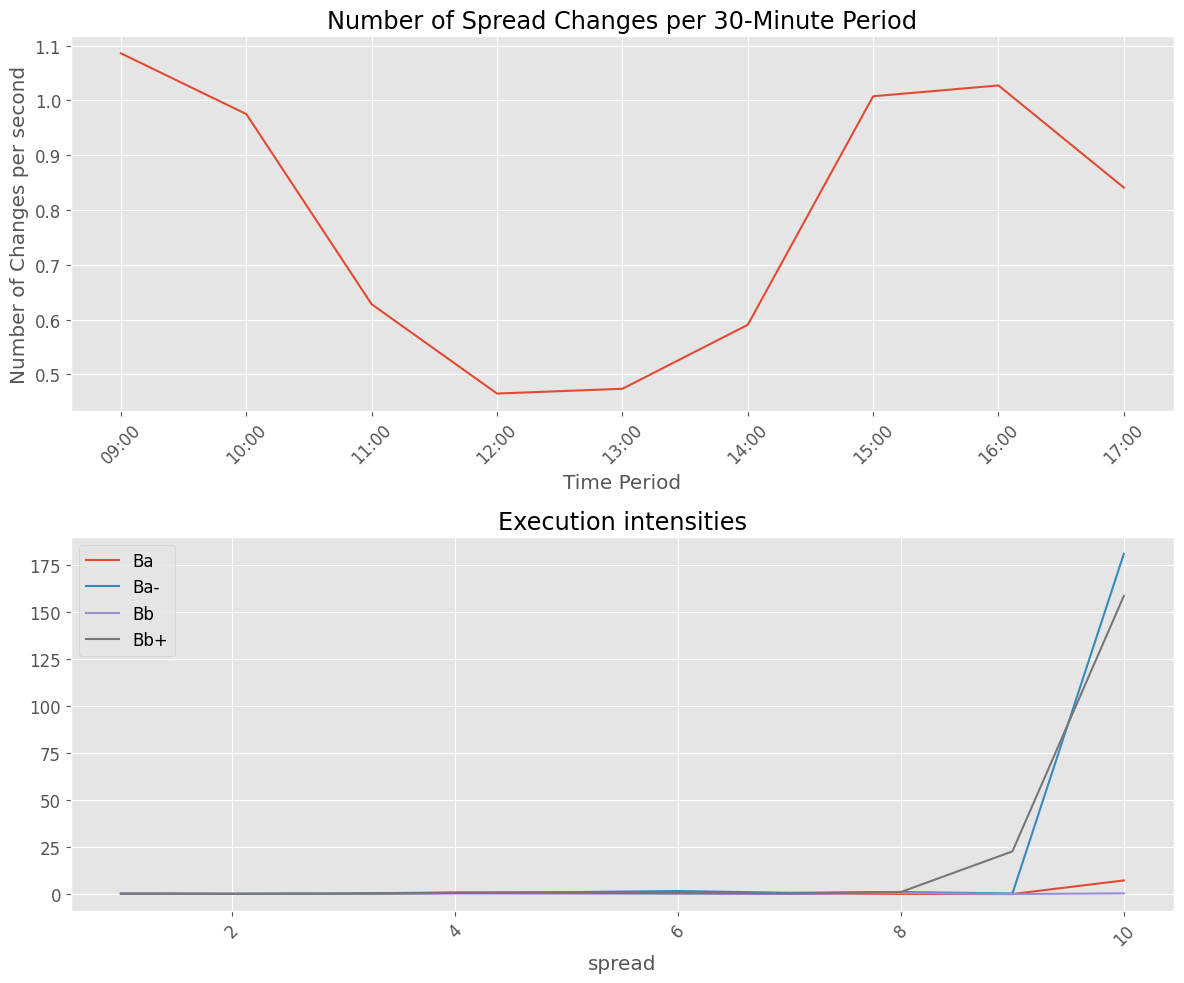

In [57]:
# Plot the results for both periods
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# 30-minute periods plot
ax1.plot(nb_transition_per_period_Bnp.index, nb_transition_per_period_Bnp.values)
ax1.set_title('Number of Spread Changes per 30-Minute Period')
ax1.set_xlabel('Time Period')
ax1.set_ylabel('Number of Changes per second')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True)

ax2.plot(intensities_tab_Bnp.index, intensities_tab_Bnp.loc[:,"Ba"], label = "Ba")
ax2.plot(intensities_tab_Bnp.index, intensities_tab_Bnp.loc[:,"Ba-"], label = "Ba-")
ax2.plot(intensities_tab_Bnp.index, intensities_tab_Bnp.loc[:,"Bb"], label = "Bb")
ax2.plot(intensities_tab_Bnp.index, intensities_tab_Bnp.loc[:,"Bb+"], label = "Bb+")
ax2.set_title('Execution intensities')
ax2.set_xlabel('spread')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [40]:
intensities_tab_Bnp

,Ba,Ba-,Bb,Bb+
1,0.261287,0.261321,0.260399,0.260418
2,0.100122,0.193989,0.102580,0.191534
3,0.160942,0.324448,0.139829,0.298263
4,0.584783,0.941862,0.329835,0.642859
5,0.722222,1.072813,0.314620,0.575837
6,1.027825,1.657902,0.202265,0.542967
7,0.345866,0.715671,0.118312,0.306459
8,0.114293,1.151841,0.564337,1.155578
9,0.053296,0.337655,0.058286,22.705681
10,7.287076,180.717781,0.421275,158.372108
